In [1]:
import torch
import torchaudio
from network import ShuffleNetV2
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import os
import librosa
import matplotlib.pyplot as plt
import numpy as np
from mobilenetv2 import mobilenetv2


d:\Anaconda\envs\py38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\Anaconda\envs\py38\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\Anaconda\envs\py38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
model=ShuffleNetV2(model_size='1.5x')

model size is  1.5x


In [3]:
sd=torch.load('./shuffle/ShuffleNetV2.1.5x.pth.tar')["state_dict"]
sd.keys()
#将sd中的key值前面的module去掉
from collections import OrderedDict
new_state_dict = OrderedDict()
for k, v in sd.items():
    name = k[7:] # remove `module.`
    new_state_dict[name] = v

In [4]:
model.load_state_dict(new_state_dict)

<All keys matched successfully>

In [5]:
model(torch.randn(1,3,224,224)).shape

torch.Size([1, 1000])

In [6]:

net=mobilenetv2()
net.load_state_dict(torch.load('mobilenetv2.pth'))
net(torch.randn(1,3,224,224)).shape

torch.Size([1, 1000])

In [7]:
import warnings
warnings.filterwarnings('ignore')

In [8]:
def get_all_wavs(path):
    wavs = []
    for root, dirs, files in os.walk(path):
        for file in files:
            if file.endswith(".wav"):
                wavs.append(os.path.join(root, file))
    return wavs

path_c='F:/数据集/illness/cough'
path_r='F:/数据集/illness/respiratory'

In [9]:
def get_label(path):
    return int(path.split('\\')[-2])

In [10]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  #im = axs.imshow(spec, origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

In [11]:
def spectrogram_r(wav):
    spec = librosa.feature.melspectrogram(wav, sr=16000, n_fft=400, hop_length=160, n_mels=128)
    return spec

def spectrogram_c(wav):
    spec = librosa.feature.melspectrogram(wav, sr=16000, n_fft=400, hop_length=160, n_mels=128)
    return spec

In [12]:
from torchvision import transforms

In [13]:
class c_dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.wavs = get_all_wavs(path)
        self.labels = [get_label(wav) for wav in self.wavs]
    def __len__(self):
        return len(self.wavs)
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.wavs[idx])
        resampler = torchaudio.transforms.Resample(sr, 16000)
        wav = resampler(wav)
        wav = wav[0].numpy()
        wav = spectrogram_c(wav)
        #补齐或截取至128等长
        if wav.shape[1] < 128:
            wav = np.pad(wav, ((0, 0), (0, 128 - wav.shape[1])), 'constant')
        else:
            wav = wav[:, :128]
        #大小缩放至224
        wav = transforms.Resize((224, 224))(torch.from_numpy(wav).unsqueeze(0)).numpy()

        #channel重复三次
        wav = np.repeat(wav, 3, axis=0)
        return torch.from_numpy(wav), self.labels[idx]

class r_dataset(Dataset):
    def __init__(self, path):
        self.path = path
        self.wavs = get_all_wavs(path)
        self.labels = [get_label(wav) for wav in self.wavs]
    def __len__(self):
        return len(self.wavs)
    def __getitem__(self, idx):
        wav, sr = torchaudio.load(self.wavs[idx])
        resampler = torchaudio.transforms.Resample(sr, 16000)
        wav = resampler(wav)
        wav = wav[0].numpy()
        wav = spectrogram_r(wav)
        #从中心点截取128，左右对称
        if wav.shape[1] < 128:
            wav = np.pad(wav, ((0, 0), (0, 128 - wav.shape[1])), 'constant')
        else:
            wav = wav[:, (wav.shape[1] - 128) // 2:(wav.shape[1] - 128) // 2 + 128]
        wav = transforms.Resize((224, 224))(torch.from_numpy(wav).unsqueeze(0)).numpy()
        wav = np.repeat(wav, 3, axis=0)
        return torch.from_numpy(wav), self.labels[idx]

In [14]:
dataset_c = c_dataset(path_c)
dataset_r = r_dataset(path_r)

In [15]:
dataset_c[0][0].shape,dataset_r[0][0].shape

(torch.Size([3, 224, 224]), torch.Size([3, 224, 224]))

In [16]:
class mymodel_r(nn.Module):
    def __init__(self):
        super().__init__()
        self.net1 = ShuffleNetV2(model_size='1.5x')
        self.net1.load_state_dict(new_state_dict)
        self.classifier =nn.Sequential(
            nn.Linear(1000, 256),
            nn.ReLU(),
            nn.Linear(256, 2)
        )
    def forward(self, x):
        x = self.net1(x)
        x = self.classifier(x)
        return x

In [17]:
device=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [18]:
model_r=mymodel_r().to(device)

model size is  1.5x


In [19]:
bs=16
#seperate the dataset into train and test 0.8 and 0.2
train_size=int(0.8*len(dataset_r))
test_size=len(dataset_r)-train_size
train_dataset,test_dataset=torch.utils.data.random_split(dataset_r,[train_size,test_size])
train_loader=DataLoader(train_dataset,batch_size=bs,shuffle=True)
test_loader=DataLoader(test_dataset,batch_size=bs,shuffle=True)

In [20]:
optimizer=torch.optim.Adam(model_r.parameters(),lr=1e-3)
loss_fn=nn.CrossEntropyLoss()

In [21]:
def train(model, train_loader, loss_fn, optimizer):
    size = len(train_loader.dataset)
    model.train()
    for batch, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        pred = model(X)
        loss = loss_fn(pred, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % 30 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test(model, test_loader, loss_fn):
    size = len(test_loader.dataset)
    num_batches = len(test_loader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in test_loader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [22]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(model_r, train_loader, loss_fn, optimizer)
    test(model_r, test_loader, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.665696  [    0/  162]
Test Error: 
 Accuracy: 48.8%, Avg loss: 1.611142 

Epoch 2
-------------------------------
loss: 0.117566  [    0/  162]
Test Error: 
 Accuracy: 48.8%, Avg loss: 11.928118 

Epoch 3
-------------------------------
loss: 0.530589  [    0/  162]
Test Error: 
 Accuracy: 48.8%, Avg loss: 2.231427 

Epoch 4
-------------------------------
loss: 0.092159  [    0/  162]
Test Error: 
 Accuracy: 56.1%, Avg loss: 0.759887 

Epoch 5
-------------------------------
loss: 0.119909  [    0/  162]
Test Error: 
 Accuracy: 65.9%, Avg loss: 0.666395 

Done!


In [23]:
torch.save(model_r.state_dict(), 'model_r_single.pth')

In [24]:
#calculate the accuracy,specificity,sensitivity on the test dataset
def score(model,test_dataset):
    model.eval()
    correct=0
    tp=0
    tn=0
    fp=0
    fn=0
    with torch.no_grad():
        for i in range(len(test_dataset)):
            X,y=test_dataset[i]
            X=X.unsqueeze(0)
            X=X.to(device)
            #y=y.to(device)
            pred=model(X)
            if pred.argmax(1)==y:
                correct+=1
            if pred.argmax(1)==1 and y==1:
                tp+=1
            if pred.argmax(1)==0 and y==0:
                tn+=1
            if pred.argmax(1)==1 and y==0:
                fp+=1
            if pred.argmax(1)==0 and y==1:
                fn+=1
    accuracy=correct/len(test_dataset)
    specificity=tn/(tn+fp)
    sensitivity=tp/(tp+fn)
    return accuracy,specificity,sensitivity

accuracy,specificity,sensitivity=score(model_r,test_dataset)
print('accuracy:',accuracy)
print('specificity:',specificity)
print('sensitivity:',sensitivity)

accuracy: 0.6585365853658537
specificity: 0.3333333333333333
sensitivity: 1.0


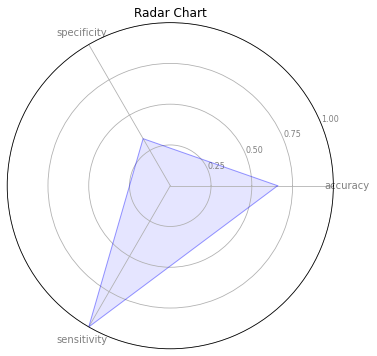

In [25]:
properties = ['accuracy','specificity','sensitivity']
values = [accuracy,specificity,sensitivity]
from math import pi

# Set the figure size
fig = plt.figure(figsize=(6, 6))
  
# Set the title of the chart
ax = fig.add_subplot(111, polar=True)
plt.title('Radar Chart')
 
# Set the angles for each axis
angles = [n / float(len(properties)) * 2 * pi for n in range(len(properties))]
angles += angles[:1]
 
# Create the radar chart
plt.xticks(angles[:-1], properties, color='grey', size=10)
plt.yticks([0.25, 0.5, 0.75, 1.0], ["0.25", "0.50", "0.75", "1.00"], color="grey", size=8)
plt.ylim(0, 1)
 
# Draw the polygon and line layers
ax.plot(angles, values + values[:1], linewidth=1, linestyle='solid', color='blue', alpha=0.4)
ax.fill(angles, values + values[:1], 'blue', alpha=0.1)
 
# Display the chart
plt.show()